# 疫学の数理モデルによる導入

<font color="teal" size="+1">高等学校の数学だけを使って CCP ウィルスの感染予測と，そこからニューラルネットワークの出力関数との関係に言及，考察する</font><br/>

- Date: 2021-0215
- Author: 浅川伸一 asakawa@ieee.org

まずは東京都の感染データを読み込んで表示


In [2]:
#!pwd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install japanize_matplotlib
import japanize_matplotlib

     |████████████████████████████████| 4.1MB 9.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=b4d2c15fd1f979015680efbfbbd850008ab8a0cd3427e56888019d026c1d0d0e
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [3]:
# 東京都のデータを確認
import json
import urllib.request

# 東京都の感染者数は https://dev-covid19-tokyo.netlify.app/ で日々公開されている 
# このサイトのソースコードは以下の GitHub で公開されているので利用させていただく
# source: https://github.com/tokyo-metropolitan-gov/covid19
tokyo_json_file = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

# 実際のデータ入手
req = urllib.request.Request(tokyo_json_file)
with urllib.request.urlopen(req) as response:
    data = json.load(response)

# 日付が '2021-02-18T08:00:00.000Z' のような書式なので先頭から 10 文字だけ
# 取り出すため，下行では x['日付'][:10] のようにしている
x = {x['日付'][:10]:int(x['小計']) for x in data['patients_summary']['data']}

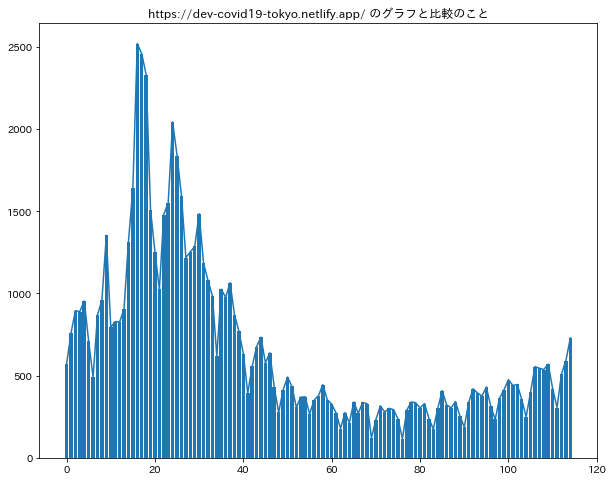

In [16]:
# `https://dev-covid19-tokyo.netlify.app/en/` のグラフと比較のこと
plt.figure(figsize=(10, 8)) # 画像のサイズ指定 (横(インチ), 縦(インチ))
n_last = 115

# 棒グラフ 
plt.bar(range(n_last), [v for v in x.values()][-n_last:])

# 折れ線グラフ
plt.plot([v for v in x.values()][-n_last:])

plt.title('https://dev-covid19-tokyo.netlify.app/ のグラフと比較のこと')
save_file_name = '2020-0518Tokyo_covid19_patients_summary.png'

# 保存する場合は，下行の行頭 # を削除する
#plt.savefig(save_file_name)

# 自分の PC にグラフをダウンロード colab 用
#from google.colab import files
#files.download(save_file_name)

Kermack と McKendrick は 1905 年から 1906 年にかけてインドで発生したコレラの大流行についての疫学的流行モデルを提案した。

- $y$: population infected 感染者数
- $x$: number of individuals still unaffected 未感染者数
- $z$: number who have been removed by recover and death 地域社会から隔離された人口（理由は問わない，隔離，死去，免疫獲得など）
- $N$: population density 地域社会の総人口 $N=x+y+z$

$\kappa$ を感染率，$\ell$ を隔離係数として Kermack=McKendrick モデルは次式で表される:

$$
\begin{cases}
\frac{dx}{dt} &= - \kappa x y\\
\frac{dy}{dt} &= \kappa x y - \ell y\\
\frac{dz}{dt} &= \ell y
\end{cases}
$$

- Reference:
Kermack and McKendrick (1927) A Contribution to the Mathematical Theory of Epidemics.

Kermack と McKendrick の感染症モデルは，3 状態モデルと呼ばれるモデルで，感染者(y)，非感染者(x)，それ以外(z) の 3 つからなる。
このモデルは **常微分方程式** で表される。
3 状態モデルではあるが，3 者を足し合わせると総人口になるため，本質的には 2 変数で考えても良い。

常微分方程式とは，上式に即して言えば，各変数が 時刻 $t$ の変化率（微分）で表現されていることを意味する。
すなわち 非感染者 x の時間変化 $\displaystyle\frac{dx}{dt}$ は，その時刻での感染者 x と非感染者 y との積で表されことを主張している。

ここで $\kappa>0$ は定数であり感染の速さを定める。

反対に 感染者はこの値 $\kappa$ と感染者と非感染者の積の大きさに応じて増加する。
（非感染者 x は減少する。なぜなら $-\kappa$ と負の値だからである）

さらに 感染者は一定の割合 $\ell$ で減少する。
この $\ell$ は，免疫を獲得する，死亡する，ワクチン接種によって抗体を獲得するなどによって集団から隔離される割合を表す。

まずは，原著論文に掲載された図を表示してみよう。


In [8]:
# 原著論文に掲載された図画像の取得
!wget https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1927Kermack_McKendrick_fig.png

--2021-04-15 12:33:32--  https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1927Kermack_McKendrick_fig.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52670 (51K) [image/png]
Saving to: ‘1927Kermack_McKendrick_fig.png’

1927Kermack_McKendr 100%[===================>]  51.44K  --.-KB/s    in 0.006s  

2021-04-15 12:33:32 (8.76 MB/s) - ‘1927Kermack_McKendrick_fig.png’ saved [52670/52670]



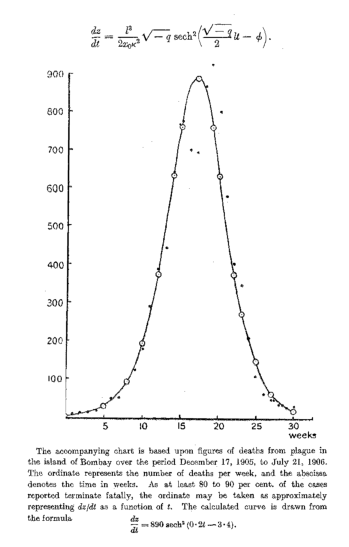

In [9]:
# 画像の表示
img = plt.imread('1927Kermack_McKendrick_fig.png')
plt.figure(figsize=(6, 10))
plt.axis(False); plt.imshow(img, cmap='gray')
plt.show()

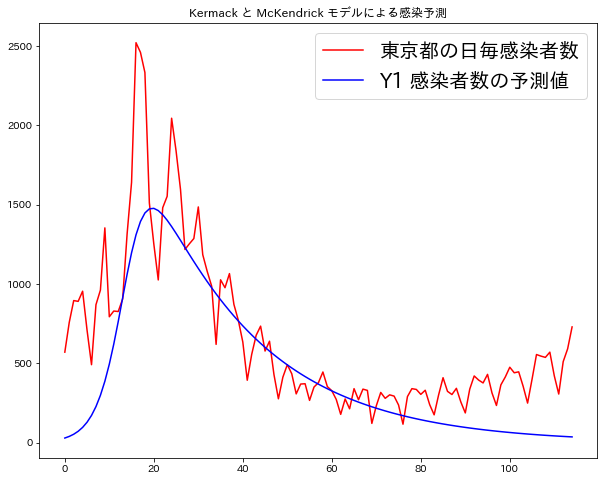

In [19]:
def KM(x0=99, y0=1, length=100, kappa=1.0, ell=1.0, dt=0.005):
    """Kermack and McKendrick differenctial equations model
    
    arguments:
    x0: float
        非感染率の初期値
    y0: float
        感染率の初期値
    length: int
        シミュレーションを繰り返す回数
    kappa: float
        感染係数 感染しやすさの目安
        大きければ感染力が強い，すなわち感染拡大率が増大することを意味する
    ell: 隔離係数
        感染者が，地域社会から隔離される率，すなわち，
        - 免疫を獲得する，
        - 抗体を持つ
        - 死亡する
        等によって，感染から除外される率を表す。
    dt: float
        時間単位の増分
    
    """
    X, Y, Z = [], [], []
    x, y, z = x0, y0, 0.
    for _ in range(length):
        dx = (-kappa * x * y) * dt
        dy = (kappa * x * y - ell * y) * dt
        dz = (ell * y) * dt
        x += dx
        y += dy
        z += dz
        X.append(x)
        Y.append(y)
        Z.append(z)

    return X, Y, Z

kappa = 1.0
l1 = 10. # 隔離係数 (現実に近い？ 緊急事態宣言のことか？)
l2 = 50.  # 隔離係数が大きい場合

#n_last = 70
_, Y1, Z1 = KM(kappa=1.0, ell=l1, length=n_last, dt=0.004)
X, Y2, Z2 = KM(kappa=1.0, ell=l2, length=n_last)
T = range(len(X))

#m = 2400 / 70
m = 0.97 * np.array([x for x in list(x.values())]).max() / n_last
plt.figure(figsize=(10, 8))  # width, height inches
plt.plot(T, [v for v in x.values()][-n_last:], c='red', label='東京都の日毎感染者数')  # 実データ

#plt.plot(T, X, c='g', label='非感染者数')  # X軸を T, Y軸を X(非感染者) 色(c)を緑(g)で描画
plt.plot(T, m * np.array(Y1), c='blue', label='Y1 感染者数の予測値')  # X軸を T, Y軸を Y1(感染者, l=l1) 色(c)を黄色(y)で描画
#plt.plot(T, m * np.array(Y2), c='red', label='Y2 感染者数')  # X軸を T, Y軸を X2(感染者, l=l2) 色(c)を緑(r)で描画
plt.legend(fontsize=20)
plt.title('Kermack と McKendrick モデルによる感染予測')
plt.show()
# plt.savefig('KM_model_output.png') グラフの保存

<!--
$\sinh(x) = \frac{\exp(x)-\exp(-x)}{2}$

$\cosh(x) = \frac{\exp(x)+\exp(-x)}{2}$

$\tanh(x) = \frac{\exp(x)-\exp(-x)}{\exp(x)+\exp(-x)}$

$\text{sech}(x) = \frac{1}{\cosh(x)}$

$\text{cosech}(x) = \frac{1}{\sinh(x)}$

$\coth(x) = \frac{\cosh(x)}{\sinh(x)}$
-->

上記のことを，さらに簡単に記述することを試みる。

Kermack McKendrick モデル (以下 KM) の解説を試みる。
感染者の割合を $y$ とし，非感染者の割合を $y$ する。
時刻 $t$ における非感染者の割合の変化率は以下のごときであることが主張されている:
$$
\frac{dx}{dt}=\kappa x\,y.
$$
表記方法によっては 時刻を明記して $y(t)$ と表記することもある。

$y$ は割合であるので $0\le y\le 1$ である。
一方，非感染者の割合は $1-y$ と表すことができので，$0\le y\le 1$ であり $y + 1 - y = 0$ が成り立つ。

東京都の感染者数は，東京都の全人口を $N$ とすれば，感染率 $y$ との積 $Ny$ である。

KM モデルの第一式 $\displaystyle\frac{dx}{dt}=-\kappa x y$ の意味は次のとおりである。
左辺は 非感染者 $x$ の時間変化，すなわち変化率の意味である。
右辺は，この変化率が 非感染者率と感染者率 $y$ との積に定数 $\kappa$ を掛けたものであることを主張している。
簡単のため $\kappa=1$ と考えれば，$\displaystyle\frac{dx}{dt}=x\,y$ である。

$x$ と $y$ は，どちらかが分かれば，1 からその値を引くことで求めることができるので，一方だけ考えれば良い。
どちらを考えても同じことになる。そこで $x$ を $1-y$ と書き換えれば，与式は次のように書くことができる:

$$
\frac{dy}{dt}=y (1-y), \hspace{3em}\text{あるいは}\hspace{3em} \frac{dx}{dt}=x(1-x)
$$

ここで，$x$ と $y$ の積が大きくなること，すなわち一日の感染者数が多くなることの意味を考える。
$x$ と $y$ との積であるから，$x$ と $y$ とを一辺とする長方形の面積を求めていることに擬（なぞら）えることができる。
この長方形の面積が大きくなるのは，正方形のとき，すなわち $x$ と $y$ とが等しいときであることが予想できる。

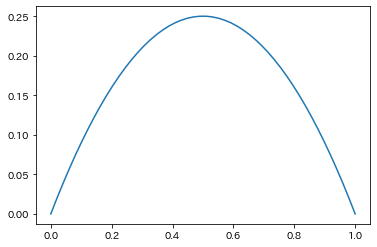

In [ ]:
p = np.linspace(0,1)  # 0 から 1 までの間を分割して，そのすべての値をまとめて p に格納
x = p      # x は p そのもの，感染者率
y = (1-x)  # ｙ は 1 から x を引いた値 すなわち 非感染者率
plt.plot(x, x * y)

直上図から，直感のとおりで正方形の面積である $x = (1-x) = y = 0.5$ のときに面積 $0.5\times 0.5=0.25$ が最大であることがわかる。
翻（ひるがえ）って，これは感染症患者数の増加率であったから，感染者と非感染者との数が同数のときに感染者の増加が最大となることが推察される。

両辺を $y(1-y)$ で割ることで，
$$
\frac{1}{y(1-y)}\frac{dy}{dt}=1.
$$

となる。LHS 第一因子はそのままでは積分できないので，部分分数に分解する。
上式 RHS 第一因子が $1/y$ と $1/(1-y)$ との和に部分分数分解できたとする。
分解してできた項の分母を $a$, $b$ と考えて次式を得る。

$$
\frac{a}{y}+\frac{b}{1-y}=\frac{1}{y(1-y)}.
$$

上式の $a$, $b$ を求めると $a=1$, $b=1$ を得る。
したがって与式 RHS は項別積分できる形に分解できる。すなわち次式のように書くことができる:

$$
\frac{1}{y(1-y)}=\frac{1}{y}+\frac{1}{1-y}.
$$

このことにより RHS は項別に積分が可能となる。
すなわち，$\displaystyle \int\frac{1}{y(1-y)}dy=\int\frac{1}{y}dy+\int\frac{1}{1-y}dy$ である。
これらの積分を実行することにより，次式を得る:

$$
\int\frac{1}{y}\;dy+\int\frac{1}{1-y}\;dy = \log|y|-\log|1-y| + C.
$$
ただし $C$ は積分定数である。

対数の引き算は対数の割り算に変換できるので
$\displaystyle\log\left(\frac{y}{1-y}\right)+C$ を得る。


$$
x - c =\log\left(\frac{y}{1-y}\right)
$$

指数と対数とは逆の操作であることに注意して
$\log x = y$ なら $e^y = x$ であるから

$$
e^{x-c}=\frac{y}{1-y}          \hspace{2em}\text{RHS の denominator を LHS へ　　　　　　　　　　　　　　　　}\\
(1-y)e^{x-c}=y                 \hspace{2em}\text{LHS を積の分配法則に従って　　　　　　　　　　　　　　　　　　　}\\
e^{x-c}-ye^{x-c}=y             \hspace{2em}\text{LHS と RHS をひっくり返して，かつ $y$ に関する項を移項　　　　}\\
y+ye^{x-c}=e^{x-c}             \hspace{2em}\text{共通項を使ってまとめる　　　　　　　　　　　　　　　　　　　　　　}\\
y\left(1+e^{x-c}\right)=e^{x-c}\hspace{2em}\text{LHS 第2因子で両辺を割る　　　　　　　　　　　　　　　　　　　　　　　　　　}\\
y = \frac{e^{x-c}}{1+e^{x-c}}  \hspace{2em}\text{LHS の numerator で nemerator と denominator を割る}\\
y = \frac{1}{1+e^{-(x-c)}}     \hspace{2em}\text{　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　}\\
$$

$$
(1-y)Ce^x=y\\
Ce^x=y+yCe^x\\
Ce^x=y(1+Ce^x)\\
y=\frac{Ce^x}{1+Ce^x}\\
y=\frac{1}{1+e^{-x}}
$$

In [ ]:
# source: https://towardsdatascience.com/say-goodbye-to-excel-a-simple-evaluation-of-python-grid-studio-using-covid-19-data-90624f322b81
import pandas as pd

# Read all data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv").dropna()

# Convert date to integer (because of Grid Studio limitation)
df.dateRep = pd.to_datetime(df.dateRep, format='%d/%m/%Y').dt.strftime('%Y%m%d').astype(int)
df

# Get Australia data
df_oz = df[df.countriesAndTerritories == 'Australia']
df_oz

df_us = df[df.geoId == 'US']
df_us

# Get Japan data
df_jp = df[df.countriesAndTerritories == 'Japan']
df_jp


# Retain only date, cases and deaths columns
df_oz = df_oz[['dateRep', 'cases', 'deaths']]
df_jp = df_jp[['dateRep', 'cases', 'deaths']]
df_us = df_us[['dateRep', 'cases', 'deaths']]

# Calculate cumulative cases & deaths
df_oz = df_oz.sort_values('dateRep', ascending=False)
df_oz['cumCases'] = df_oz.cases.cumsum()
df_oz['cumDeaths'] = df_oz.deaths.cumsum()

# Calculate cumulative cases & deaths
df_jp = df_jp.sort_values('dateRep', ascending=False)
df_jp['cumCases'] = df_jp.cases.cumsum()
df_jp['cumDeaths'] = df_jp.deaths.cumsum()

# Calculate cumulative cases & deaths
df_us = df_us.sort_values('dateRep')
df_us['cumCases'] = df_us.cases.cumsum()
df_us['cumDeaths'] = df_us.deaths.cumsum()
df_jp
#print(df_jp['cumDeaths'].head(7))

import matplotlib.pyplot as plt
xx = list(df_jp['dateRep'])[-10:]
#plt.xlabel(xx)
plt.bar(range(190), df_jp['cases'].tail(190))